# DSA4212 Assignment 1: Group 24
Ang Ming Liang
Bharath
Song Haolong
Chen YiJia

# FINAL MODEL FILE
Train/Val/Test: 91.80% / 82.23% / 76.0%

In [21]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time

np.random.seed(42)

In [2]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [3]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-7b4b85dc-20d5-d9e1-73dd-e71ac5b4dda8)
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
85G


# Connect to Google Drive & Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/DSA4212 G24/data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DSA4212 G24/data


In [5]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train_all = np.load("assignment_1_train.npz")
data_train_LRFlip = np.load("assignment_1_train_FlipLR.npz")
data_test = np.load("assignment_1_test.npz")

X_train_all = data_train_all["img"].astype(np.float32) / 255.   # set pixel intensities to [0,1]
X_train_all = np.concatenate((X_train_all, data_train_LRFlip["img"].astype(np.float32) / 255.)) # concatenate augmented data
X_test = data_test["img"].astype(np.float32) / 255.
Y_train_all = data_train_all["label"].astype(int)
Y_train_all = np.concatenate((Y_train_all, data_train_LRFlip["label"].astype(int))) # concatenate augmented data
Y_test = data_test["label"].astype(int)


_,H,W,C = X_train_all.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [6]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train_all))
np.random.shuffle(indices_shuffled)
X_train_all = X_train_all[indices_shuffled]
Y_train_all = Y_train_all[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_test))
np.random.shuffle(indices_shuffled)
X_test = X_test[indices_shuffled]
Y_test = Y_test[indices_shuffled]

In [7]:
sz_train = X_train_all.size * X_train_all.itemsize / 2.**30
sz_val = X_test.size * X_test.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 3.40 Go
Validaton Set Size: 0.71 Go


# Split Train / Validation / Test

The test set can only be used for the final evaluation of the model: one cannot use the test set when tuning the models. Consequently, we are going to split `X_train_all` into a train-set and a validation-set.

In [8]:
len_train_all = len(X_train_all)
len_train = int(0.8 * len_train_all)
len_val = len_train_all - len_train
len_tets = len(X_test)

X_train = X_train_all[:len_train]
Y_train = Y_train_all[:len_train]

X_val = X_train_all[len_train:]
Y_val = Y_train_all[len_train:]


In [9]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [10]:
import jax
import jax.numpy as jnp
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [11]:
class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class SimpleCNN(nn.Module):
    """ a simple convolutional neural network """
    kernel_size: Sequence[int]  # sequence -- CNN kernel size in each layer
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
          x = nn.Conv(features=feat_dim, kernel_size=(self.kernel_size[i],self.kernel_size[i]),
                      strides = 2, padding='SAME', name=f'layers_{i}_1',
                      kernel_init=nn.initializers.lecun_normal(),
                      bias_init=nn.initializers.zeros)(x)
          x = LayerNorm()(x)
          x = nn.selu( x)
          x = nn.max_pool(x, window_shape = (2, 2))
          
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.log_softmax(x)
        return probas

In [12]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(kernel_size=[3,3,3], n_filters=[32,64, 128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 94k


In [13]:
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * pred, axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [14]:
@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = net.apply(params, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [15]:
niter = 3000
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the ADAM optimizer
optimizer = optax.chain(
    optax.adamw(learning_rate=1e-2, weight_decay=1e-5),
    optax.scale_by_schedule(
        step_size_fn=optax.exponential_decay(
            init_value=1,
            decay_rate=0.95,
            transition_steps=niter,
            transition_begin=int(niter*0.25)
        )
    )
)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [16]:
# put data to GPU
X_train = jax.device_put(X_train)
X_val = jax.device_put(X_val)

In [17]:
batch_size = 512

sub_rngs = jax.random.split(key_, batch_size)

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

# Set up early stopping variables
best_val_loss = float("inf")
patience = 5
counter = 0

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]
  #X_batch = vec_transform(sub_rngs, X_batch)

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}siec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")
    # Check for early stopping
    if loss_val < best_val_loss:
        best_val_loss = loss_val
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Stopping early...")
            break

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

  0%|          | 0/3000 [00:00<?, ?it/s]

Time:4.7siec 	 Epoch:0.0 	 Loss [2.34 / 2.33] 	 Accuracy Train/Valid: [7.62% / 6.84%]
Time:12.4siec 	 Epoch:1.8 	 Loss [1.78 / 1.75] 	 Accuracy Train/Valid: [39.26% / 42.19%]
Time:14.0siec 	 Epoch:3.5 	 Loss [1.35 / 1.34] 	 Accuracy Train/Valid: [57.03% / 58.59%]
Time:15.6siec 	 Epoch:5.2 	 Loss [1.17 / 1.13] 	 Accuracy Train/Valid: [64.45% / 66.21%]
Time:17.1siec 	 Epoch:6.9 	 Loss [0.93 / 1.05] 	 Accuracy Train/Valid: [70.51% / 67.19%]
Time:18.7siec 	 Epoch:8.6 	 Loss [0.84 / 0.92] 	 Accuracy Train/Valid: [73.05% / 72.27%]
Time:20.2siec 	 Epoch:10.4 	 Loss [0.82 / 0.87] 	 Accuracy Train/Valid: [76.76% / 73.24%]
Time:21.8siec 	 Epoch:12.1 	 Loss [0.76 / 0.85] 	 Accuracy Train/Valid: [80.47% / 73.63%]
Time:23.3siec 	 Epoch:13.8 	 Loss [0.73 / 0.78] 	 Accuracy Train/Valid: [79.30% / 76.76%]
Time:24.8siec 	 Epoch:15.5 	 Loss [0.69 / 0.77] 	 Accuracy Train/Valid: [80.47% / 77.15%]
Time:26.3siec 	 Epoch:17.2 	 Loss [0.66 / 0.76] 	 Accuracy Train/Valid: [82.23% / 75.78%]
Time:27.9siec 	 Epo

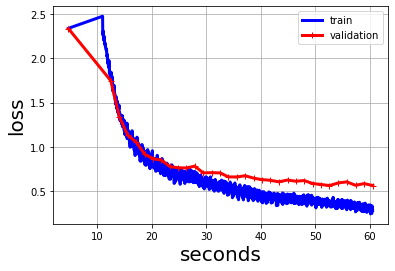

In [18]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()

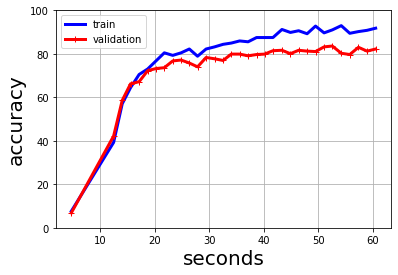

In [19]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

# Test Accuracy
Note we have at no point used the test-set previously.

In [20]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Test Accuracy: 76.0%
